# PPE: A PDA-based Reconstruction

**Expected time to run through: ~2 hrs**

In this section, we illustrate the basic paleoclimate data assimilation (PDA) workflow with `cfr`, conducting a pseudoproxy experiment (PPE) with the pseudoPAGES2k dataset.
Our goal is to reconstruct the global air surface temperature field.

Required data to complete this tutorial:

- iCESM simulated air surface temperature: [tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc](https://atmos.washington.edu/~rtardif/LMR/prior/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc)
- iCESM simulated precipitation rate: [pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc](https://atmos.washington.edu/~rtardif/LMR/prior/pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc)
- pseudoPAGES2k: [ppwn_SNRinf_rta.nc](https://github.com/fzhu2e/paper-pseudoPAGES2k/raw/main/data/ppwn_SNRinf_rta.nc)

In [1]:
%load_ext autoreload
%autoreload 2

import cfr
import numpy as np

import os
os.chdir('/glade/u/home/fengzhu/Github/cfr/docsrc/notebooks/')

## Paleoclimate data assimilation (PDA) steps
### Create a reconstruction job object `cfr.ReconJob` and load the pseudoPAGES2k database

A `cfr.ReconJob` object takes care of the workflow of a reconstruction task.
It provides a series of attributes and methods to help the users go through each step of the reconstruction task, such as loading the proxy database, loading the model prior, calibrating and running the proxy system models, performing the data assimilation solver, etc.

(800.0, 2000.0)

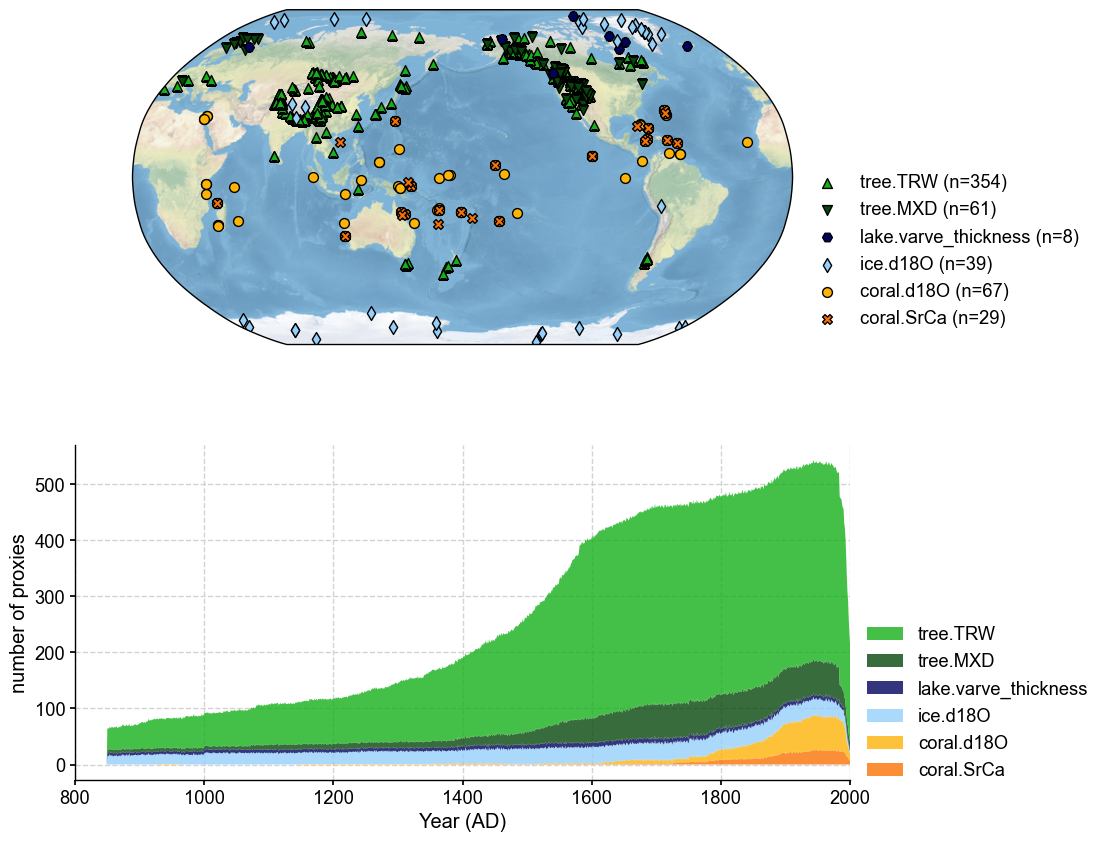

In [2]:
# create a reconstruction job object using the `cfr.ReconJob` class
job = cfr.ReconJob()

# load the pseudoPAGES2k database from a netCDF file
job.proxydb = cfr.ProxyDatabase().load_nc('./data/ppwn_SNRinf_rta.nc')

# plot to have a check of the database
fig, ax = job.proxydb.plot(plot_count=True)
ax['count'].set_xlim(800, 2000)

### Load the model prior (iCESM simulated tas & pr fields)

The `job.load_clim()` method loads gridded climate data from netCDF files and calculate anomalies based on given reference time interval (`anom_period`).
`tag='prior'` denotes that the loaded data will be used as the model prior.

In [3]:
job.load_clim(
    tag='prior',
    path_dict={
        'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc',
        'pr': './data/pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc',
    },
    anom_period=(1951, 1980),  # calculate anomalies against the reference interval 1951-1980 CE
    load=True,  # load the data into memeory to accelerate the later access; requires large memeory
    verbose=True,
)

>>> job.configs["prior_path"] = {'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc', 'pr': './data/pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc'}
>>> job.configs["prior_anom_period"] = (1951, 1980)
>>> job.configs["prior_lat_name"] = lat
>>> job.configs["prior_lon_name"] = lon
>>> job.configs["prior_time_name"] = time
>>> prior variables ['tas', 'pr'] loaded
>>> job.prior created


### Load the instrumental observations

As a perfect model prior pseudoproxy experiment (PPE), we use the iCESM simulated fields as instrumental observations.
Therefore, this step looks similar to the previous one, except for `tag='obs'`.

In [4]:
job.load_clim(
    tag='obs',
    path_dict={
        'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc',
        'pr': './data/pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc',
    },
    anom_period=(1951, 1980),
    load=True,  # load the data into memeory to accelerate the later access; requires large memeory
    verbose=True,
)

>>> job.configs["obs_path"] = {'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc', 'pr': './data/pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc'}
>>> job.configs["obs_anom_period"] = (1951, 1980)
>>> job.configs["obs_lat_name"] = lat
>>> job.configs["obs_lon_name"] = lon
>>> job.configs["obs_time_name"] = time
>>> obs variables ['tas', 'pr'] loaded
>>> job.obs created


### Setup the proxy system models (PSMs) for different proxy types

We need to provide settings for the proxy system models before they can be properly calibrated, including:

- PSM to be used for each proxy type; if not set, `'Linear'` will be used by default,
- seasonality for each proxy type; if not set, the calendar annual `[1,2,3,4,5,6,7,8,9,10,11,12]` will be used by default.

In [5]:
# PSM to be used
ptype_psm_dict = {
    'tree.TRW': 'Bilinear',
    'tree.MXD': 'Linear',
    'coral.d18O': 'Linear',
    'coral.SrCa': 'Linear',
    'ice.d18O': 'Linear',
    'lake.varve_thickness': 'Linear',
}

# Seasonality for each proxy type
ptype_season_dict = {
    'tree.TRW': [  # expert curated pool of possible growing seasons
        [1,2,3,4,5,6,7,8,9,10,11,12],
        [6,7,8],
        [3,4,5,6,7,8],
        [6,7,8,9,10,11],
        [-12,1,2],
        [-9,-10,-11,-12,1,2],
        [-12,1,2,3,4,5],
    ],
    'tree.MXD': [  # expert curated pool of possible growing seasons
        [1,2,3,4,5,6,7,8,9,10,11,12],
        [6,7,8],
        [3,4,5,6,7,8],
        [6,7,8,9,10,11],
        [-12,1,2],
        [-9,-10,-11,-12,1,2],
        [-12,1,2,3,4,5],
    ],
    'coral.d18O': list(range(1, 13)),            # annual
    'coral.SrCa': list(range(1, 13)),            # annual
    'ice.d18O': list(range(1, 13)),              # annual
    'lake.varve_thickness': list(range(1, 13)),  # annual
}

### Calibrate the PSMs

Since the seasonality for TRW and MXD is undetermined, it can take a while to search for the optimal growing season for each site of TRW and MXD.

In [6]:
job.calib_psms(
    ptype_psm_dict=ptype_psm_dict,
    ptype_season_dict=ptype_season_dict,
    verbose=True,)

>>> job.configs["ptype_psm_dict"] = {'coral.SrCa': 'Linear', 'tree.MXD': 'Linear', 'tree.TRW': 'Bilinear', 'lake.varve_thickness': 'Linear', 'ice.d18O': 'Linear', 'coral.d18O': 'Linear'}
>>> job.configs["ptype_season_dict"] = {'coral.SrCa': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'tree.MXD': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [6, 7, 8], [3, 4, 5, 6, 7, 8], [6, 7, 8, 9, 10, 11], [-12, 1, 2], [-9, -10, -11, -12, 1, 2], [-12, 1, 2, 3, 4, 5]], 'tree.TRW': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [6, 7, 8], [3, 4, 5, 6, 7, 8], [6, 7, 8, 9, 10, 11], [-12, 1, 2], [-9, -10, -11, -12, 1, 2], [-12, 1, 2, 3, 4, 5]], 'lake.varve_thickness': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'ice.d18O': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'coral.d18O': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}
>>> job.configs["psm_calib_period"] = [1850, 2015]


Calibrating the PSMs:  13%|█▎        | 72/558 [15:44<1:13:27,  9.07s/it]

The number of overlapped data points is 15 < 25. Skipping ...


Calibrating the PSMs:  15%|█▍        | 83/558 [17:36<1:08:16,  8.62s/it]

The number of overlapped data points is 23 < 25. Skipping ...


Calibrating the PSMs:  23%|██▎       | 128/558 [26:50<1:17:08, 10.76s/it]

The number of overlapped data points is 22 < 25. Skipping ...


Calibrating the PSMs:  24%|██▍       | 133/558 [28:03<1:21:40, 11.53s/it]

The number of overlapped data points is 19 < 25. Skipping ...


Calibrating the PSMs:  49%|████▊     | 272/558 [52:12<21:12,  4.45s/it]  

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  57%|█████▋    | 318/558 [1:02:06<44:18, 11.08s/it]  

The number of overlapped data points is 6 < 25. Skipping ...


Calibrating the PSMs:  57%|█████▋    | 319/558 [1:02:06<31:16,  7.85s/it]

The number of overlapped data points is 14 < 25. Skipping ...


Calibrating the PSMs:  59%|█████▉    | 332/558 [1:04:34<26:04,  6.92s/it]  

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  60%|██████    | 336/558 [1:04:53<13:46,  3.72s/it]

The number of overlapped data points is 4 < 25. Skipping ...


Calibrating the PSMs:  85%|████████▌ | 476/558 [1:34:08<13:37,  9.97s/it]

The number of overlapped data points is 8 < 25. Skipping ...


Calibrating the PSMs: 100%|█████████▉| 556/558 [1:49:37<00:19,  9.75s/it]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs: 100%|██████████| 558/558 [1:49:37<00:00, 11.79s/it]

>>> PSM for Asi_243 failed to be calibrated.
>>> PSM for Ocn_144 failed to be calibrated.
>>> PSM for Ant_022 failed to be calibrated.
>>> PSM for Ocn_145 failed to be calibrated.
>>> PSM for Ocn_138 failed to be calibrated.
>>> PSM for Arc_045 failed to be calibrated.
>>> PSM for Asi_238 failed to be calibrated.
>>> PSM for Ant_016 failed to be calibrated.
>>> PSM for Ant_015 failed to be calibrated.
>>> PSM for Ant_014 failed to be calibrated.
>>> PSM for Arc_014 failed to be calibrated.
>>> 547 records tagged "calibrated" with ProxyRecord.psm created


Note that PSMs cannot be calibrated at some sites due to the limited available data points over the instrumental period. These sites will be skipped for data assimilation.

### Run the PSMs

In [7]:
job.forward_psms(verbose=True)

Forwarding the PSMs: 100%|██████████| 547/547 [04:45<00:00,  1.92it/s]

>>> ProxyRecord.pseudo created for 547 records


### Annualize the model prior fields

This step will determine the temporal resolution of the reconstructed fields.

In [8]:
job.annualize_clim(tag='prior', verbose=True, months=list(range(1, 13)))

>>> job.configs["prior_annualize_months"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
>>> Processing tas ...
>>> Processing pr ...
>>> job.prior updated


### Regrid the model prior fields

This step will determine the spatial resolution of the reconstructed fields.

In [9]:
job.regrid_clim(tag='prior', nlat=42, nlon=63, verbose=True)

>>> job.configs["prior_regrid_nlat"] = 42
>>> job.configs["prior_regrid_nlon"] = 63
>>> Processing tas ...
>>> Processing pr ...


### (Optional) Save the job object for later reload

Save the job object before running the DA procedure for a quick reload next time if needed.

In [10]:
job.save('./cases/pp2k-ppe-pda', verbose=True)

>>> job.configs["save_dirpath"] = ./cases/pp2k-ppe-pda
>>> prior_tas saved to: ./cases/pp2k-ppe-pda/prior_tas.nc
>>> prior_pr saved to: ./cases/pp2k-ppe-pda/prior_pr.nc
>>> obs_tas saved to: ./cases/pp2k-ppe-pda/obs_tas.nc
>>> obs_pr saved to: ./cases/pp2k-ppe-pda/obs_pr.nc
>>> job saved to: ./cases/pp2k-ppe-pda/job.pkl


Now let's reload the job object from the saved directory.

In [11]:
job = cfr.ReconJob()
job.load('./cases/pp2k-ppe-pda/', verbose=True)

>>> job is loaded
>>> job.prior["pr"].da is loaded
>>> job.prior["tas"].da is loaded
>>> job.obs["pr"].da is loaded
>>> job.obs["tas"].da is loaded


### Run the DA solver with Monte-Carlo iterations

By default, 100 yrs (set by `job.configs['nens']`) of the climate states are randomly picked from the pool of the model prior and 75% (set by `job.configs['assim_frac']`) of the proxies are randomly picked and assimilated in each Monte-Carlo iteration.

As an example, we set `recon_seeds = list(range(1, 3))` and run two iterations, to save running time.
For any serious scientific experiments, we should set `recon_seeds = list(range(1, 21))` or so.
The larger number of iterations, the more robust the reconstruction will be.

By default, `recon_vars=['tas']` and only the field of the air surface temperature will be reconstructed.
To reconstruct more variables at once, simply add the variable names into the list.
For instance, to reconstruct also the precipitation field, set `recon_vars['tas', 'pr']`.
Or, the additional variables can be reconstructed separately, e.g., set `recon_vars['pr']` in a second call of `job.run_da_mc()`.

In [12]:
job.run_da_mc(
    save_dirpath='./recons/pp2k-ppe-pda',
    recon_seeds=list(range(1, 3)),  # as an example here
    recon_vars=['tas'],  # add 'pr' to reconstruct both the tas and pr fields
    recon_period=[800, 2000],
    verbose=True,
)

>>> job.configs["recon_period"] = [800, 2000]
>>> job.configs["recon_loc_rad"] = 25000
>>> job.configs["recon_timescale"] = 1
>>> job.configs["recon_vars"] = ['tas']
>>> job.configs["nens"] = 100
>>> job.configs["recon_seeds"] = [1, 2]
>>> job.configs["assim_frac"] = 0.75
>>> job.configs["save_dirpath"] = ./recons/pp2k-ppe-pda
>>> job.configs["compress_params"] = {'zlib': True}
>>> job.configs["output_full_ens"] = False
>>> job.configs["recon_sampling_mode"] = fixed
>>> job.configs["trim_prior"] = True
>>> job.configs["allownan"] = False
>>> seed: 1 | max: 2


KF updating: 100%|██████████| 1201/1201 [14:49<00:00,  1.35it/s]


>>> Reconstructed fields saved to: ./recons/pp2k-ppe-pda/job_r01_recon.nc
>>> seed: 2 | max: 2


KF updating: 100%|██████████| 1201/1201 [19:06<00:00,  1.05it/s]


>>> Reconstructed fields saved to: ./recons/pp2k-ppe-pda/job_r02_recon.nc
>>> DONE! Total time spent: 36.40 mins.


## Validation steps

### Create the reconstruction result object `cfr.ReconRes`.

A `cfr.ReconRes` object takes care of the workflow of postprocessing and analyzing the reconstruction results.
It provides handy methods to help the users load, validate, and visualize the reconstruction results.

In [13]:
res = cfr.ReconRes('./recons/pp2k-ppe-pda', verbose=True)

>>> res.paths:
['./recons/pp2k-ppe-pda/job_r01_recon.nc', './recons/pp2k-ppe-pda/job_r02_recon.nc']


### Load the reconstructed variables

Here we validate the `tas` field and the NINO3.4 index as an example.

In [14]:
res.load(['tas', 'nino3.4'], verbose=True)

>>> ReconRes.recons["tas"] created
>>> ReconRes.da["tas"] created
>>> ReconRes.recons["nino3.4"] created
>>> ReconRes.da["nino3.4"] created


### Validate the reconstructed NINO3.4

We calculate the annualized NINO3.4 from the "instrumental observations" as a reference for validation.

In [15]:
da = job.obs['tas'].annualize().da
da = cfr.utils.geo_mean(da, lat_min=-5, lat_max=5, lon_min=np.mod(-170, 360), lon_max=np.mod(-120, 360))
ref_time = da.time.values
ref_value = da.values
ref_name = 'truth'

We use a chain calling of several methods, including the validation step `.validate()` and the plotting step `.plot_qs()`.

(800.0, 2000.0)

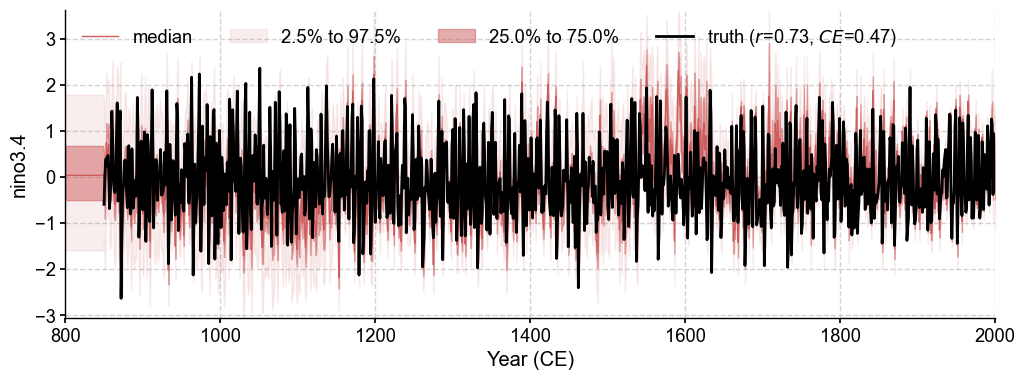

In [16]:
fig, ax = res.recons['nino3.4'].compare(ref_time, ref_value, ref_name).plot_qs()
ax.set_xlim(800, 2000)

### Validate the reconstructed fields

In [17]:
# Preparations to add markers representing the sites on the map

lats, lons, colors, markers, markersizes = {}, {}, {}, {}, {}
for pid, pobj in job.proxydb.filter(by='tag', keys=['calibrated']).records.items():
    lats[pid] = pobj.lat
    lons[pid] = pobj.lon
    colors[pid] = cfr.visual.STYLE.colors_dict[pobj.ptype]
    markers[pid] = cfr.visual.STYLE.markers_dict[pobj.ptype]
    markersizes[pid] = 50

Calculating and visualizing the coefficient of determination ($R^2$) between the reconstructed and target fields, we see overall high skills where the proxies are densely located (e.g., the west US), and overall low skill where the proxies are sparsely located (e.g., the southern ocean regions), except for the tropical Pacific regions, where climatic teleconnection helps a lot on the reconstruction quality even if the number of the local proxies are limited.

Since the majority of the pseudoproxies are generated by process-based PSMs (e.g., `tree.TRW` and `ice.d18O`), applying linear regression based PSMs in the data assimilation cycle introduces biases due to the inaccurate representation of the observation operators (PSMs).
This partially explains the low skill regions near the ice core and tree-ring width records.

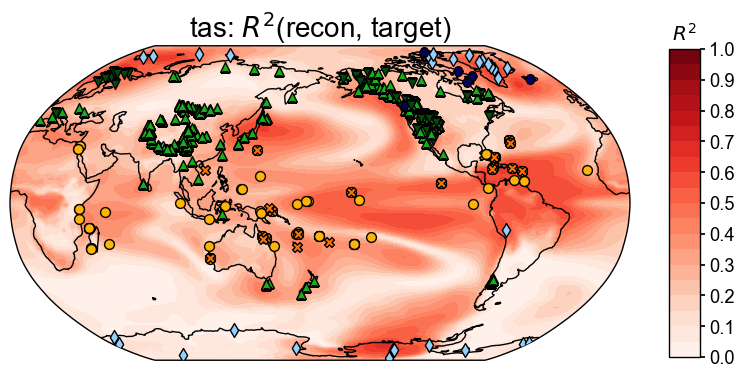

In [18]:
stat = 'R2'
valid_fd = res.recons['tas'].compare(
    job.obs['tas'].annualize(), stat=stat,
    timespan=(850, 1850),
)
fig, ax = valid_fd.plot(
    title=fr'tas: $R^2$(recon, target)',
    add_cyclic_point=True,
    site_lats=lats, site_lons=lons,
    site_markersize=markersizes, site_marker=markers,
    site_color=colors, cbar_title_y=1,
)

In contrast to $R^2$, the coefficient of efficiency ($CE$) measures not only the linear correlation between two timeseries, but also the bias in amplitude.
Calculating and visualizing $CE$ between the reconstructed and the target fields, we see overall similar spatial patterns of the high and low skill regions.

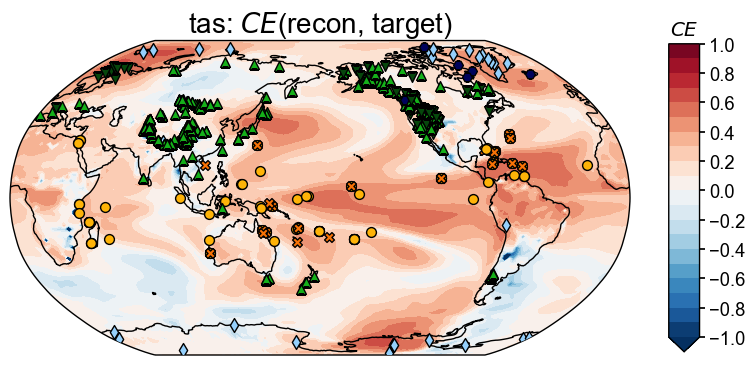

In [19]:
stat = 'CE'
valid_fd = res.recons['tas'].compare(
    job.obs['tas'].annualize(), stat=stat,
    timespan=(850, 1850),
)
fig, ax = valid_fd.plot(
    title=fr'tas: $CE$(recon, target)',
    add_cyclic_point=True,
    site_lats=lats, site_lons=lons,
    site_markersize=markersizes, site_marker=markers,
    site_color=colors, cbar_title_y=1,
)